# 01_setup_y_descarga

In [ ]:
# Celda 1: Subir kaggle.json
from google.colab import files

print("📁 Por favor, sube tu archivo kaggle.json")
print("   (El que acabas de descargar de Kaggle)")

uploaded = files.upload()

📁 Por favor, sube tu archivo kaggle.json
   (El que acabas de descargar de Kaggle)


Saving kaggle.json to kaggle.json


In [ ]:
import os

# Crear carpeta .kaggle
!mkdir -p ~/.kaggle

# Copiar el archivo kaggle.json a la carpeta correcta
!cp kaggle.json ~/.kaggle/

# Darle permisos correctos (seguridad)
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API configurada correctamente!")

✅ Kaggle API configurada correctamente!


In [ ]:
!pip install -q kaggle

print("✅ Kaggle instalado!")

✅ Kaggle instalado!


In [ ]:
#Descargar Dataset
print("Descargando dataset de rayos x...")

#crear carpeta para los datos
# !mkdir -p /content/data

#desacarga dataset de kaggle
!kaggle datasets download -d muhammadrehan00/chest-xray-dataset -p /content/data

print("Descarga completada!")

Descargando dataset de rayos x...
Dataset URL: https://www.kaggle.com/datasets/muhammadrehan00/chest-xray-dataset
License(s): CC-BY-NC-SA-4.0
100% 3.04G/3.05G [00:48<00:00, 42.5MB/s]
100% 3.05G/3.05G [00:48<00:00, 67.9MB/s]
Descarga completada!


In [ ]:
#Descomprimir dataset
import zipfile

print("Descomprimiendo dataset...")

#Descomprimir
with zipfile.ZipFile('/content/data/chest-xray-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/data')

print("Dataset descomprimido!")


Descomprimiendo dataset...
Dataset descomprimido!


In [ ]:
print("Estructura del dataset")
print("="*50)

#listar carpetas principales
data_path = "/content/data"

for folder in os.listdir(data_path):
  folder_path = os.path.join(data_path, folder)
  if os.path.isdir(folder_path):
    print(f"\n {folder}")
    #listar subcarpetas
    for subfolder in os.listdir(folder_path):
      subfolder_path = os.path.join(folder_path, subfolder)
      if os.path.isdir(subfolder_path):
        #contar imagenes
        num_images = len([f for f in os.listdir(subfolder_path)
                          if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"└─ {subfolder}: {num_images} imágenes")
print("\n" + "="*50)



Estructura del dataset

 test
└─ tuberculosis: 1064 imágenes
└─ pneumonia: 580 imágenes
└─ normal: 925 imágenes

 val
└─ tuberculosis: 1064 imágenes
└─ pneumonia: 570 imágenes
└─ normal: 900 imágenes

 train
└─ tuberculosis: 8513 imágenes
└─ pneumonia: 4674 imágenes
└─ normal: 7263 imágenes



# 02_analisis_exploratorio

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

#configurar estilo de gráficos
plt.style.use('default')
sns.set_palette('husl')

In [ ]:
def analyze_dataset_distribution(data_path):
  #Función que analiza la distribución de imágenes del dataset
  data_path = Path(data_path)
  #Diccionario ppara guardar estadísticas
  stats = {
      'split': [],
      'class': [],
      'count': []
  }

  #Explorar cada split
  for split in ['train', 'val', 'test']:
    split_path = data_path / split
    if not split_path.exists():
      continue
    #Explorar cada clase
    for class_name in os.listdir(split_path):
      class_path = split_path / class_name
      #Contar imágenes
      if class_path.exists():
        #Cuenta los archivos contenidos en las carpes evitando carpetas adicionales o archivos ocultos.
        num_images = len([f for f in os.listdir(class_path)
                     if os.path.isfile(os.path.join(class_path, f))
                     and not f.startswith('.')])

        #Guardar estadísticas
        stats['split'].append(split)
        stats['class'].append(class_name)
        stats['count'].append(num_images)
  return pd.DataFrame(stats)

df_stats = analyze_dataset_distribution(data_path)

print("📊 DISTRIBUCIÓN DEL DATASET")
print("=" * 60)
print(df_stats)
print("=" * 60)

📊 DISTRIBUCIÓN DEL DATASET
   split         class  count
0  train  tuberculosis   8513
1  train     pneumonia   4674
2  train        normal   7263
3    val  tuberculosis   1064
4    val     pneumonia    570
5    val        normal    900
6   test  tuberculosis   1064
7   test     pneumonia    580
8   test        normal    925


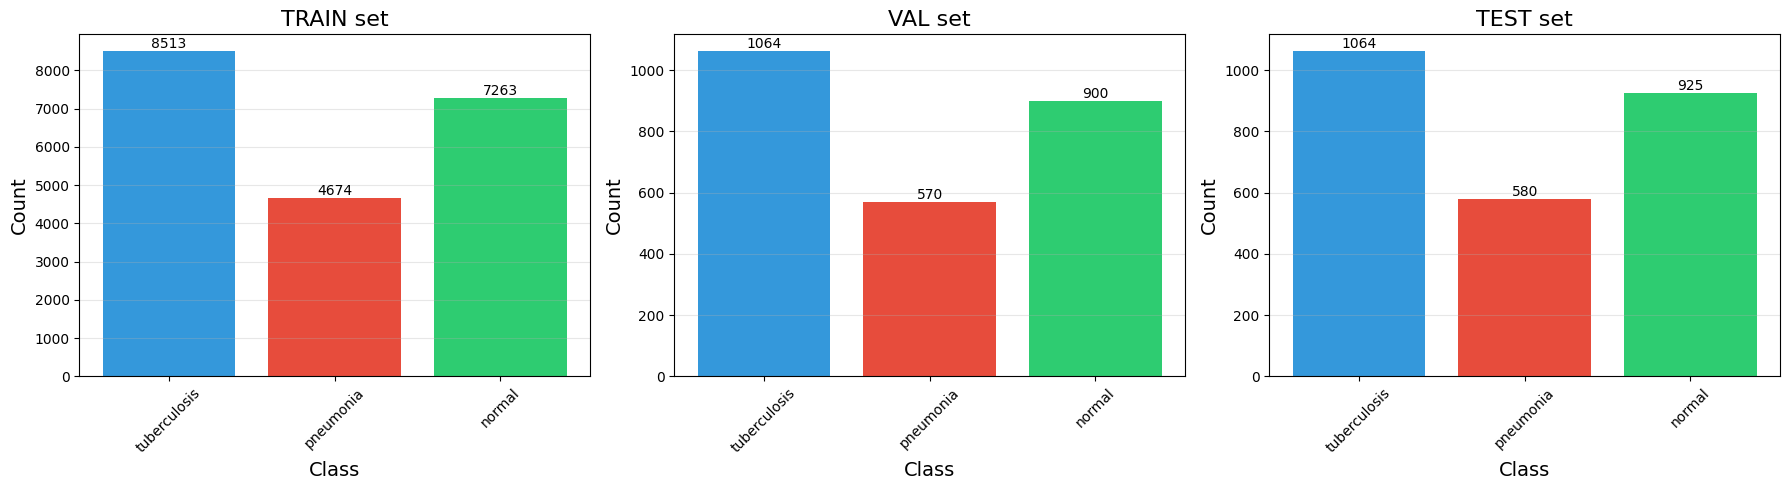

totales por clase:
totals: class
normal           9088
pneumonia        5824
tuberculosis    10641
Name: count, dtype: int64, 
 percentage: class
normal          35.565296
pneumonia       22.791844
tuberculosis    41.642860
Name: count, dtype: float64


In [ ]:
#Visualización de distribución

fig,axes = plt.subplots(1,3, figsize = (18,5))

splits = ['train', 'val', 'test']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, split in enumerate(splits):
  split_df = df_stats[df_stats['split'] == split]

  ax = axes[i]
  bars = ax.bar(split_df['class'], split_df['count'], color = colors)

  #Agregar valores encima de las barras
  for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha = 'center', va = 'bottom')

  ax.set_title(f'{split.upper()} set', fontsize = 16)
  ax.set_xlabel('Class', fontsize = 14)
  ax.set_ylabel('Count', fontsize = 14)
  ax.tick_params(axis = 'x', rotation = 45)
  ax.grid(axis = 'y', alpha = 0.3)

plt.tight_layout()
plt.show()

print("totales por clase:")
totals = df_stats.groupby('class')['count'].sum()
percentage = totals / totals.sum() * 100
print(f"totals: {totals}, \n percentage: {percentage}")

In [ ]:
#Análisis de desbalance de clases

train_data = df_stats[df_stats['split'] == 'train']
count = train_data['count'].values
max_count = np.max(count)
min_count = np.min(count)
ratio = max_count / min_count

print(f"Clase con más imágenes: {train_data[train_data['count']==max_count]['class'].values[0]}")
print(f"Número de imágenes:{max_count}")
print(f"Clase con menos imágenes: {train_data[train_data['count']==min_count]['class'].values[0]}")
print(f"Número de imágenes:{min_count}")
print(f"Ratio de desbalance: {ratio}")

if ratio>2:
  print("Dataset significativamente desbalanceado")
  print("\n💡 Recomendaciones:")
  print("   1. Usar 'class weights' en la función de pérdida")
  print("   2. Considerar técnicas de data augmentation más agresivas")
  print("   3. Evaluar con métricas balanceadas (F1-score, no solo accuracy)")
elif ratio > 1.5:
  print("Dataset levemente desbalanceado")
  print("\n💡 Recomendación: Usar class weights")
else:
  print("Dataset razonablemente balanceado")


Clase con más imágenes: tuberculosis
Número de imágenes:8513
Clase con menos imágenes: pneumonia
Número de imágenes:4674
Ratio de desbalance: 1.82135216089003
Dataset levemente desbalanceado

💡 Recomendación: Usar class weights


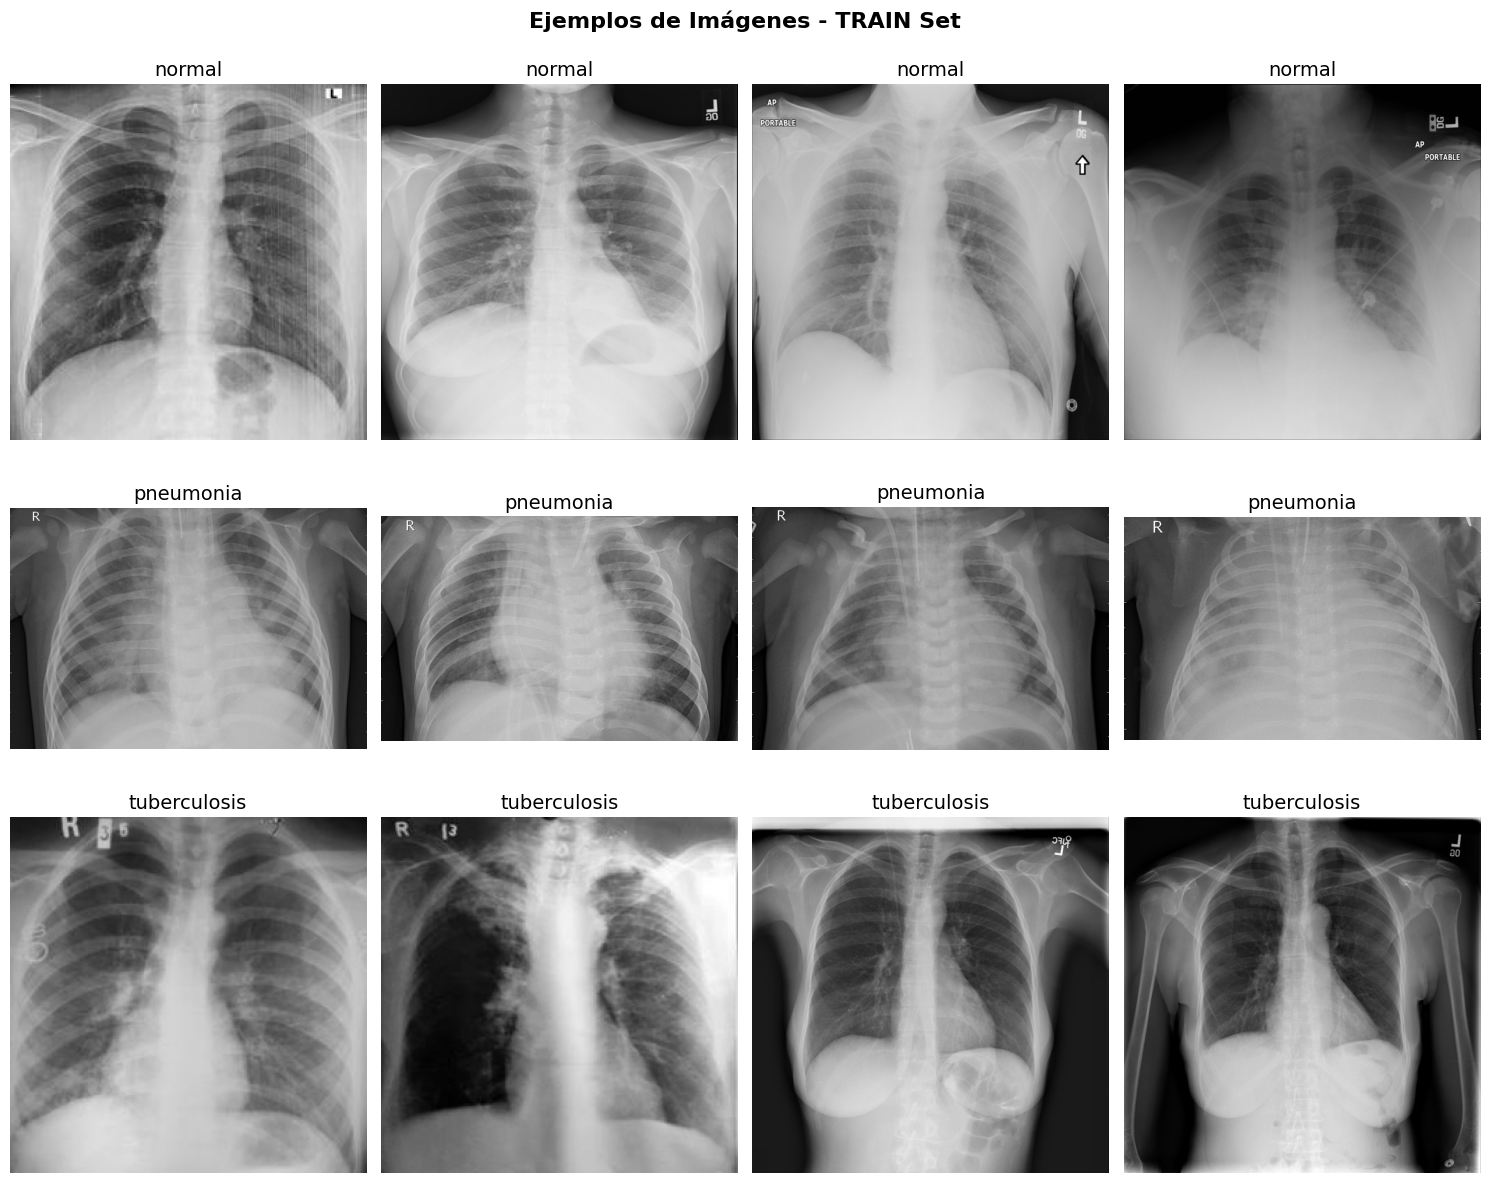

In [ ]:
#mostrar imágenes de ejemplo
import random

def show_sample_img(data_path, split='train', samples_per_class = 3):
  #Funcion que muestra imagenes de ejemplo de cada clase
  data_path = Path(data_path)
  classes= ['normal', 'pneumonia', 'tuberculosis']

  fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15,12))
  fig.suptitle(f"Ejemplos de Imágenes - {split.upper()} Set", fontsize  = 16, fontweight = 'bold', y=0.995)

  for i, class_name in enumerate(classes):
    class_path = data_path / split / class_name
    images = [f for f in os.listdir(class_path)
          if f.endswith(('.jpg', '.jpeg', '.png'))]
    samples = random.sample(images, min(samples_per_class, len(images)))

    for j, sample in enumerate(samples):
      img_path = class_path / sample
      img = Image.open(img_path)
      axes[i,j].imshow(img)
      axes[i,j].axis('off')
      axes[i,j].set_title(class_name, fontsize = 14)

      if j == 0:
        axes[i,j].set_ylabel(class_name, fontsize = 14)
  plt.tight_layout()
  plt.show()

show_sample_img(data_path, split = 'train', samples_per_class= 4)


In [ ]:
#Analizar tamaño de las imágenes

def analyze_img_dimensions(data_path, split = 'train', sample_size = 100):
  #Analiza las dimensiones de las imágenes en el dataset
  data_path = Path(data_path)
  classes = ['normal', 'pneumonia', 'tuberculosis']
  dim = {
      'width':[],
      'height':[],
      'class':[]
  }

  for class_name in classes:
    class_path = data_path/split/class_name

    #obtener imágenes
    images = [f for f in class_path.iterdir()
          if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

    sample = random.sample(images, min(sample_size, len(images)))
    for img_path in sample:
      img = Image.open(img_path)
      width, height = img.size
      dim['width'].append(width)
      dim['height'].append(height)
      dim['class'].append(class_name)
  return pd.DataFrame(dim)

print("Analizando dimensiones de imágenes")
df_dims = analyze_img_dimensions(data_path, split='train', sample_size=200)
print("Dimensiones analizadas")

print("=" * 50)
print(df_dims.groupby('class')[['width', 'height']].describe())
print("=" * 50)


Analizando dimensiones de imágenes
Dimensiones analizadas
              width                                                      \
              count     mean         std    min     25%     50%     75%   
class                                                                     
normal        200.0   890.02  426.778748  256.0   512.0  1024.0  1024.0   
pneumonia     200.0  1336.76  371.340438  479.0  1054.0  1301.0  1554.0   
tuberculosis  200.0   366.20  151.142217  144.0   256.0   256.0   512.0   

                     height                                             \
                 max  count     mean         std    min    25%     50%   
class                                                                    
normal        2178.0  200.0  841.195  354.327769  256.0  512.0  1024.0   
pneumonia     2844.0  200.0  976.020  369.648916  211.0  712.0   871.0   
tuberculosis  1024.0  200.0  362.400  154.377466  191.0  256.0   256.0   

                               
              

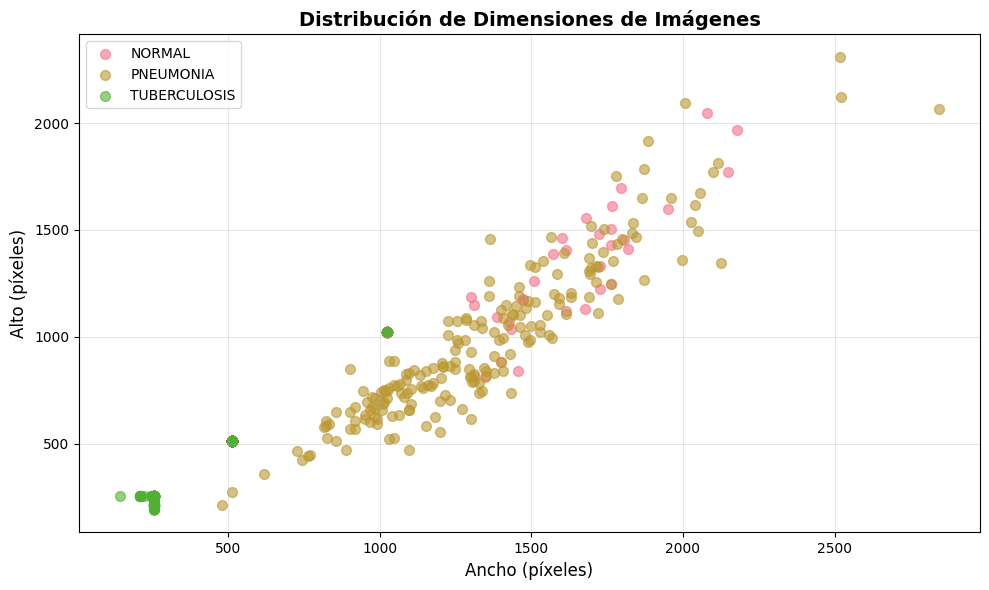


📏 Tamaño más común:
   512x512 píxeles


In [ ]:
fig,ax = plt.subplots(1,1, figsize = (10,6))

for class_name in ['normal', 'pneumonia', 'tuberculosis']:
  df_class = df_dims[df_dims['class']==class_name]
  ax.scatter(df_class['width'], df_class['height'], alpha = 0.6, s=50, label = class_name.upper())

ax.set_xlabel('Ancho (píxeles)', fontsize=12)
ax.set_ylabel('Alto (píxeles)', fontsize=12)
ax.set_title('Distribución de Dimensiones de Imágenes',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Tamaño más común
print("\n📏 Tamaño más común:")
mode_width = df_dims['width'].mode()[0]
mode_height = df_dims['height'].mode()[0]
print(f"   {mode_width}x{mode_height} píxeles")


In [ ]:
# Celda 9: Resumen del análisis exploratorio
print("=" * 70)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 70)

print("\n TAMAÑO DEL DATASET:")
print(f"   • Total de imágenes: {df_stats['count'].sum():,}")
print(f"   • Train: {df_stats[df_stats['split']=='train']['count'].sum():,}")
print(f"   • Validation: {df_stats[df_stats['split']=='val']['count'].sum():,}")
print(f"   • Test: {df_stats[df_stats['split']=='test']['count'].sum():,}")

print("\n DISTRIBUCIÓN DE CLASES:")
totals = df_stats.groupby('class')['count'].sum()
for class_name, count in totals.items():
    pct = (count / totals.sum()) * 100
    print(f"{class_name.capitalize():15s}: {count:5,} ({pct:5.1f}%)")

train_counts = df_stats[df_stats['split']=='train']['count'].values
ratio = train_counts.max() / train_counts.min()
print(f"\n BALANCE:")
print(f"   • Ratio de desbalance: {ratio:.2f}:1")
if ratio > 2:
    print(f"   • Significativamente desbalanceado")
elif ratio > 1.5:
    print(f"⚡Levemente desbalanceado")
else:
    print(f"Razonablemente balanceado")

print(f"\n DIMENSIONES DE IMÁGENES:")
print(f"   • Rango de anchos: {df_dims['width'].min()}-{df_dims['width'].max()} px")
print(f"   • Rango de altos: {df_dims['height'].min()}-{df_dims['height'].max()} px")
print(f"   • Tamaño más común: {df_dims['width'].mode()[0]}x{df_dims['height'].mode()[0]} px")

print("\n" + "=" * 70)
print("Análisis completado. Listo para preprocesamiento y entrenamiento.")
print("=" * 70)

RESUMEN DEL ANÁLISIS EXPLORATORIO DE DATOS

 TAMAÑO DEL DATASET:
   • Total de imágenes: 25,553
   • Train: 20,450
   • Validation: 2,534
   • Test: 2,569

 DISTRIBUCIÓN DE CLASES:
   • Normal         : 9,088 ( 35.6%)
   • Pneumonia      : 5,824 ( 22.8%)
   • Tuberculosis   : 10,641 ( 41.6%)

 BALANCE:
   • Ratio de desbalance: 1.82:1
   • ⚡ Levemente desbalanceado

 DIMENSIONES DE IMÁGENES:
   • Rango de anchos: 144-2844 px
   • Rango de altos: 191-2310 px
   • Tamaño más común: 512x512 px

Análisis completado. Listo para preprocesamiento y entrenamiento.



# 03_procesamiento_y_dataloaders

In [ ]:
#importar librerías adicionales necesarias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

#Verificar versiones
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
  print(f"GPU name: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU name: Tesla T4


In [ ]:
data_path = "/content/data"

if os.path.exists(data_path):
    print(f"✅ Dataset encontrado: {data_path}")
else:
    print(f"Dataset NO encontrado: {data_path}")

CONFIG = {
    'image_size': 224,
    'batch_size': 32,
    'num_workers': 0,
    'classes': ['normal', 'pneumonia', 'tuberculosis'],
    'num_classes': 3
}

print("\n📋 CONFIGURACIÓN:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

✅ Dataset encontrado: /content/data

📋 CONFIGURACIÓN:
  image_size: 224
  batch_size: 32
  num_workers: 0
  classes: ['normal', 'pneumonia', 'tuberculosis']
  num_classes: 3


In [ ]:
#Tranformaciones para el entrenamiento
#estadísticas de ImageNet - estandar para transfer learning
IMAGENET_MEAN = [0.485,0.459]
IMAGENET_STD = [0.229, 0.224, 0.225]

#transformaciones para split 'train' - con augmentation
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),           # Flip horizontal 50%
    transforms.RandomRotation(degrees=10),            # Rotación ±10°
    transforms.ColorJitter(brightness=0.2,            # Brillo ±20%
                          contrast=0.2),              # Contraste ±20%
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
#transformaciones para spits 'val' y 'test'
val_test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])



In [ ]:
# Celda 4: Clase ChestXRayDataset
class ChestXRayDataset(Dataset):
    def __init__(self, data_path, split='train', transform=None):
        self.data_path = Path(data_path)
        self.split = split
        self.transform = transform
        self.classes = CONFIG['classes']
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_path = self.data_path / split / class_name
            if not class_path.exists():
                print(f"{class_path} no existe")
                continue
            class_images = [f for f in class_path.iterdir()
                           if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
            self.images.extend(class_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(class_images))

        print(f"{split.upper()}: {len(self.images):,} imágenes")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.images[idx]).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            black_img = torch.zeros(3, 224, 224)
            return black_img, self.labels[idx]


In [ ]:
#Creación de instancias de datasets para los splits

#train dataset
train_dataset = ChestXRayDataset(data_path,
                                 split = 'train',
                                 transform = train_transforms)

#validation dataset
val_dataset = ChestXRayDataset(data_path,
                               split = 'val',
                               transform = val_test_transforms)

#test dataset
test_dataset = ChestXRayDataset(data_path,
                                split = 'test',
                                transform = val_test_transforms)

print(f"Train: {len(train_dataset):,} imágenes")
print(f"Val:   {len(val_dataset):,} imágenes")
print(f"Test:  {len(test_dataset):,} imágenes")
print(f"Total: {len(train_dataset) + len(val_dataset) + len(test_dataset):,} imágenes")

TRAIN: 20,450 imágenes
VAL: 2,534 imágenes
TEST: 2,569 imágenes
Train: 20,450 imágenes
Val:   2,534 imágenes
Test:  2,569 imágenes
Total: 25,553 imágenes


In [ ]:
#Calcular pesos para mejorar el desbalance

from collections import Counter

print("Distribución de clases (train):")

class_counts = Counter(train_dataset.labels)
total_samples = len(train_dataset)

for class_idx, class_name in enumerate(CONFIG['classes']):
  count = class_counts[class_idx]
  percentage = (count/total_samples)*100
  print(f"{class_name.capitalize():15s}:{count:5,}({percentage:5.2f}%)")

#calcular pesos (inversamente proporcional a la frecuencia)
#clases con más imágenes tendra un peso menor

class_weights = []
for class_idx in range(CONFIG['num_classes']):
  count = class_counts[class_idx]
  weight = total_samples/(CONFIG['num_classes']*count)
  class_weights.append(weight)

#convertir a tensor
class_weights = torch.FloatTensor(class_weights)

#Mostar pesos
print(f"\nCLASS WEIGHTS (para balancear):")
print("=" * 60)
for class_idx, class_name in enumerate(CONFIG['classes']):
    print(f"  {class_name.capitalize():15s}: {class_weights[class_idx]:.4f}")
print("=" * 60)

print("\nEstos pesos se usarán en la función de pérdida")
print("para darle más importancia a las clases minoritarias")

Distribución de clases (train):
Normal         :7,263(35.52%)
Pneumonia      :4,674(22.86%)
Tuberculosis   :8,513(41.63%)

CLASS WEIGHTS (para balancear):
  Normal         : 0.9385
  Pneumonia      : 1.4584
  Tuberculosis   : 0.8007

Estos pesos se usarán en la función de pérdida
para darle más importancia a las clases minoritarias


In [ ]:
#Crear Dataloaders

train_loader = DataLoader(
    train_dataset,
    batch_size = CONFIG['batch_size'],
    shuffle = True,
    num_workers = CONFIG['num_workers'],
    pin_memory = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = CONFIG['batch_size'],
    shuffle = False,
    num_workers = CONFIG['num_workers'],
    pin_memory = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = CONFIG['batch_size'],
    shuffle = False,
    num_workers = CONFIG['num_workers'],
    pin_memory = True
)

print("DataLoaders creados correctamente")
print(f"Número de batches:")
print(f"  Train: {len(train_loader)} batches de {CONFIG['batch_size']} imágenes")
print(f"  Val:   {len(val_loader)} batches")
print(f"  Test:  {len(test_loader)} batches")

DataLoaders creados correctamente
Número de batches:
  Train: 640 batches de 32 imágenes
  Val:   80 batches
  Test:  81 batches


In [ ]:
# Celda 8: Función de visualización (SIN normalización para ver mejor)
def show_batch(dataloader, num_images=8):
    """
    Muestra un batch de imágenes.
    NOTA: Esta función crea un mini-dataset temporal sin normalización
    para poder visualizar correctamente.
    """
    # Obtener el dataset original del dataloader
    dataset = dataloader.dataset

    # Crear transformación SOLO para visualización (sin normalización)
    viz_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()  # Solo convertir a tensor, SIN normalizar
    ])

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    # Tomar índices aleatorios
    indices = random.sample(range(len(dataset)), min(num_images, len(dataset)))

    for plot_idx, img_idx in enumerate(indices):
        # Cargar imagen directamente
        img_path = dataset.images[img_idx]
        img = Image.open(img_path).convert('RGB')

        # Aplicar SOLO resize y to_tensor (sin normalización)
        img_tensor = viz_transforms(img)

        # Convertir a numpy y grayscale
        img_array = img_tensor.permute(1, 2, 0).numpy()
        img_gray = img_array.mean(axis=2)

        # Mostrar
        axes[plot_idx].imshow(img_gray, cmap='gray')
        axes[plot_idx].axis('off')

        # Título
        label = dataset.labels[img_idx]
        class_name = CONFIG['classes'][label]
        axes[plot_idx].set_title(f'{class_name.upper()}',
                                 fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

print("✅ Función de visualización definida")

✅ Función de visualización definida


🖼️  Ejemplos de TRAIN (con data augmentation):


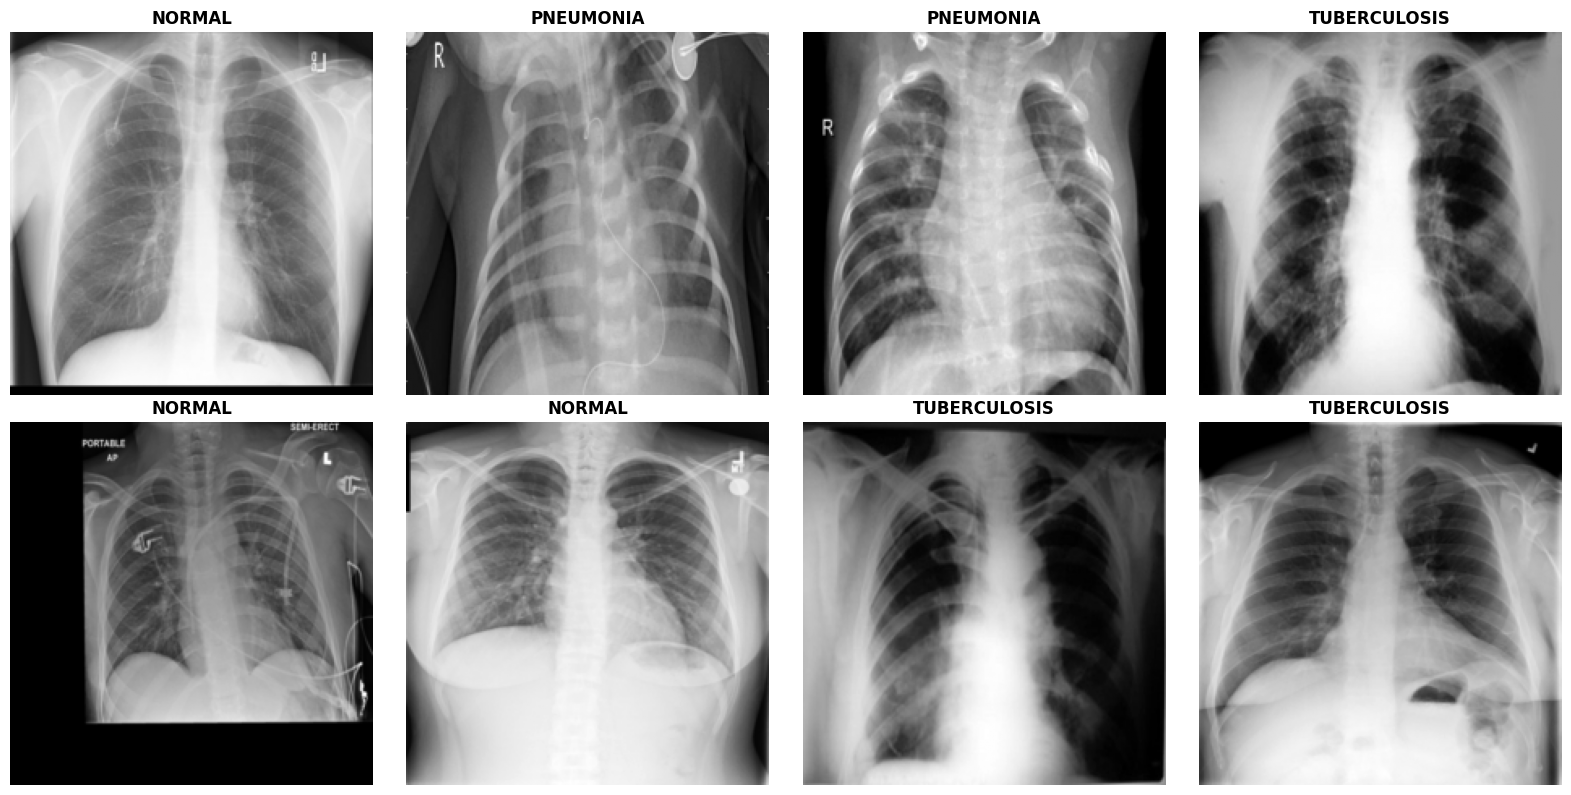

In [ ]:
# Celda 9: Visualizar ejemplos de TRAIN (con augmentation)
print("🖼️  Ejemplos de TRAIN (con data augmentation):")
show_batch(train_loader, num_images=8)

🖼️  Ejemplos de VAL (sin data augmentation):


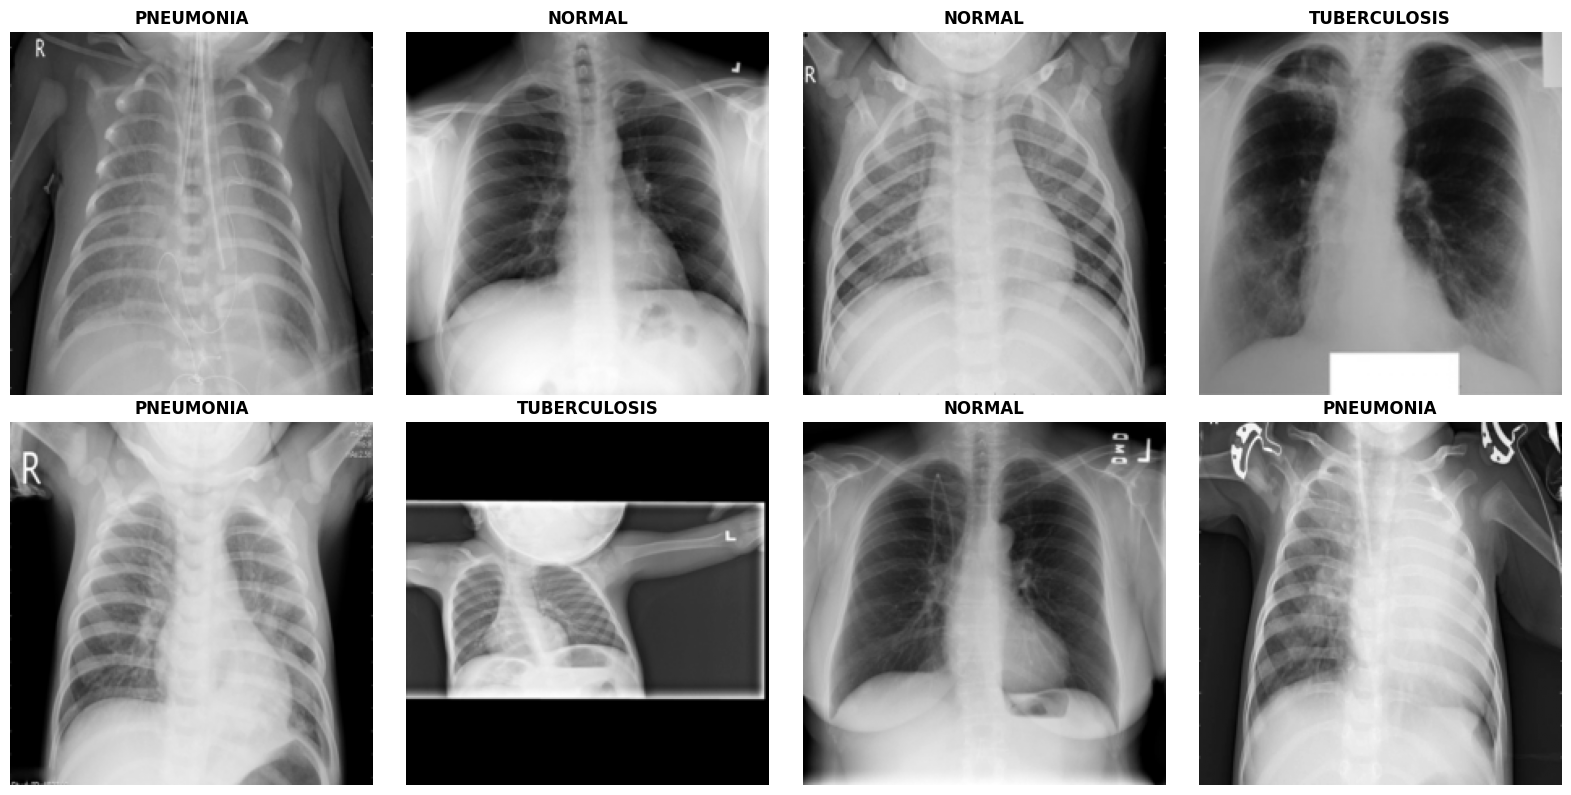

In [ ]:
# Celda 10: Visualizar ejemplos de VAL (sin augmentation)
print("🖼️  Ejemplos de VAL (sin data augmentation):")
show_batch(val_loader, num_images=8)

# 04_entrnamiento_modelo


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib as Path
from PIL import Image
import time
from collections import Counter
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

#Verificación de configuración del sistema
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
    print(f"Device seleccionado: {device}")
else:
    device = torch.device('cpu')
    print(f"GPU no disponible, usando CPU")
    print(f"Device seleccionado: {device}")


PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA disponible: True
CUDA version: 12.6
GPU: Tesla T4
Device seleccionado: cuda


In [ ]:
data_path = "/content/data"

CONFIG = {
    'image_size': 224,
    'batch_size': 32,
    'num_workers': 0,
    'classes': ['normal', 'pneumonia', 'tuberculosis'],
    'num_classes': 3,
    'learning_rate': 0.001,
    'num_epochs': 20,
    'patience': 5  # Para early stopping
}

print("=" * 60)

for key, value in CONFIG.items():
    print(f"  {key:20s}: {value}")
print("=" * 60)

  image_size          : 224
  batch_size          : 32
  num_workers         : 0
  classes             : ['normal', 'pneumonia', 'tuberculosis']
  num_classes         : 3
  learning_rate       : 0.001
  num_epochs          : 20
  patience            : 5


In [ ]:
#Recrear pipeline de datos
from pathlib import Path as PathLib  # Renombrar para evitar conflictos

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transformaciones
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Transformaciones definidas")

# Clase Dataset
class ChestXRayDataset(Dataset):
    def __init__(self, data_path, split='train', transform=None):
        self.data_path = PathLib(data_path)  # ✅ Usar PathLib
        self.split = split
        self.transform = transform
        self.classes = CONFIG['classes']
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_path = self.data_path / split / class_name
            if not class_path.exists():
                continue
            class_images = [f for f in class_path.iterdir()
                           if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
            self.images.extend(class_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(class_images))

        print(f"  {split.upper()}: {len(self.images):,} imágenes")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.images[idx]).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            black_img = torch.zeros(3, 224, 224)
            return black_img, self.labels[idx]

print("Clase ChestXRayDataset definida")

# Crear datasets
print("\nCreando datasets...")
train_dataset = ChestXRayDataset(data_path, 'train', train_transforms)
val_dataset = ChestXRayDataset(data_path, 'val', val_test_transforms)
test_dataset = ChestXRayDataset(data_path, 'test', val_test_transforms)

# Calcular class weights
from collections import Counter
class_counts = Counter(train_dataset.labels)
total_samples = len(train_dataset)
class_weights = []
for class_idx in range(CONFIG['num_classes']):
    count = class_counts[class_idx]
    weight = total_samples / (CONFIG['num_classes'] * count)
    class_weights.append(weight)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"\nClass weights: {class_weights.cpu().numpy()}")

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nDataLoaders creados")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Transformaciones definidas
Clase ChestXRayDataset definida

Creando datasets...
  TRAIN: 20,450 imágenes
  VAL: 2,534 imágenes
  TEST: 2,569 imágenes

Class weights: [0.93854696 1.4584224  0.8007361 ]

DataLoaders creados
  Train batches: 640
  Val batches: 80
  Test batches: 81


In [ ]:
#Creación del modelo

model = models.efficientnet_b0(pretrained=True)

print("EfficientNet-b0 cargado correctamente")
print(f"Número de parámetros: {sum(p.numel() for p in model.parameters()):,}")

print("Classifier original:")
print(model.classifier)

#modificar la última capa para 3 clases
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, CONFIG['num_classes'])

print("\nClassifier modificado:")
print(model.classifier)

#Mover modelo a GPU
model = model.to(device)

print(f"\nModelo movido a: {device}")
print("=" * 60)

#contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total de parámetros: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 52.3MB/s]


EfficientNet-b0 cargado correctamente
Número de parámetros: 5,288,548
Classifier original:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Classifier modificado:
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

Modelo movido a: cuda
Total de parámetros: 4,011,391
Parámetros entrenables: 4,011,391


In [ ]:
#Loss Function y Optimizador

#Loss function con class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

#Optimizador
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

print("Loss function y optimizador definidos")

#learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)


Loss function y optimizador definidos


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    #Entrenar el modelo por una sola epoca
    model.train()
    running_loss = 0.0
    running_corrects= 0
    total_samples = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss=criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += images.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion,device):
  #Evalua el modelo
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  total_samples = 0

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data)
      total_samples += images.size(0)

      #Calcular métricas
  epoch_loss = running_loss / total_samples
  epoch_acc = running_corrects.double() / total_samples

  return epoch_loss, epoch_acc


In [ ]:
#Entrenamiento

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
   'lr':[]
}
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
  epoch_start_time = time.time()
  print(f"\nÉpoca {epoch+1}/{CONFIG['num_epochs']}")

  train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc = validate(model, val_loader, criterion, device)

  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_acc)
  history['lr'].append(optimizer.param_groups[0]['lr'])

  scheduler.step(val_loss)

  epoch_time = time.time() - epoch_start_time

 # Imprimir resultados
  print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
  print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
  print(f"LR: {optimizer.param_groups[0]['lr']:.6f} | Tiempo: {epoch_time:.1f}s")

  # Guardar mejor modelo
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      epochs_no_improve = 0
      print(f"✅ Nuevo mejor modelo guardado (Val Loss: {val_loss:.4f})")
  else:
      epochs_no_improve += 1
      print(f"⏳ {epochs_no_improve} época(s) sin mejora")

  # Early stopping
  if epochs_no_improve >= CONFIG['patience']:
      print(f"\n⚠️  Early stopping activado (sin mejora por {CONFIG['patience']} épocas)")
      break

# Tiempo total
total_time = time.time() - start_time
print("\n" + "=" * 60)
print(f"✅ ENTRENAMIENTO COMPLETADO")
print(f"⏱️  Tiempo total: {total_time/60:.1f} minutos")
print(f"🏆 Mejor Val Loss: {best_val_loss:.4f}")
print("=" * 60)

# Cargar mejor modelo
model.load_state_dict(best_model_wts)
print("\n✅ Mejor modelo cargado")


Época 1/20
Train Loss: 0.4521 | Train Acc: 0.7503
Val Loss:   0.4053 | Val Acc:   0.7707
LR: 0.001000 | Tiempo: 507.8s
✅ Nuevo mejor modelo guardado (Val Loss: 0.4053)

Época 2/20
Train Loss: 0.4051 | Train Acc: 0.7659
Val Loss:   0.4024 | Val Acc:   0.7711
LR: 0.001000 | Tiempo: 504.6s
✅ Nuevo mejor modelo guardado (Val Loss: 0.4024)

Época 3/20
Train Loss: 0.3959 | Train Acc: 0.7686
Val Loss:   0.4289 | Val Acc:   0.7680
LR: 0.001000 | Tiempo: 500.8s
⏳ 1 época(s) sin mejora

Época 4/20
Train Loss: 0.3882 | Train Acc: 0.7696
Val Loss:   0.4275 | Val Acc:   0.7751
LR: 0.001000 | Tiempo: 502.0s
⏳ 2 época(s) sin mejora

Época 5/20
Train Loss: 0.3802 | Train Acc: 0.7732
Val Loss:   0.4135 | Val Acc:   0.7684
LR: 0.001000 | Tiempo: 508.7s
⏳ 3 época(s) sin mejora

Época 6/20
Train Loss: 0.3812 | Train Acc: 0.7708
Val Loss:   0.3840 | Val Acc:   0.7703
LR: 0.001000 | Tiempo: 502.8s
✅ Nuevo mejor modelo guardado (Val Loss: 0.3840)

Época 7/20
Train Loss: 0.3844 | Train Acc: 0.7693
Val Loss: 

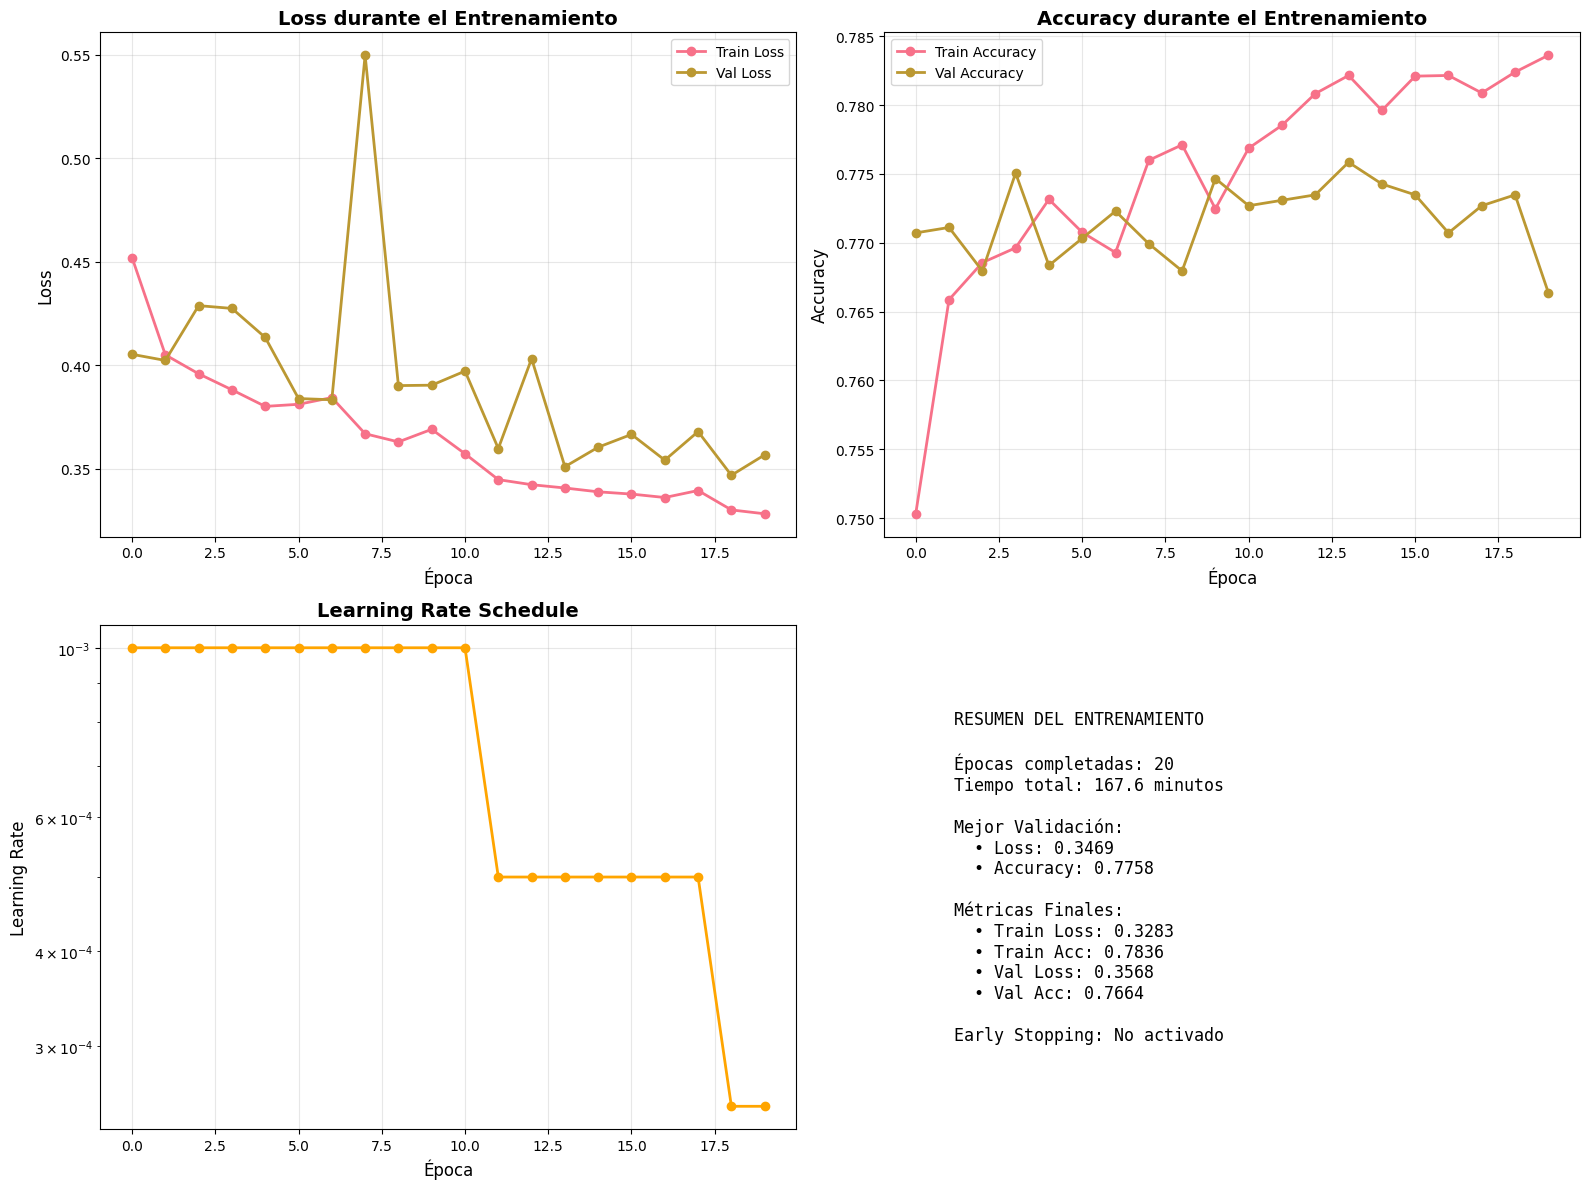

✅ Visualización de entrenamiento completada


In [ ]:
# Celda 8: Visualizar curvas de entrenamiento (CORREGIDA)
import numpy as np

# Convertir tensors de GPU a CPU/numpy si es necesario
def to_numpy(data):
    """Convierte tensors a numpy arrays"""
    if isinstance(data, list):
        return [to_numpy(item) for item in data]
    elif torch.is_tensor(data):
        return data.cpu().numpy() if data.is_cuda else data.numpy()
    else:
        return data

# Preparar datos para graficar
train_loss = to_numpy(history['train_loss'])
train_acc = to_numpy(history['train_acc'])
val_loss = to_numpy(history['val_loss'])
val_acc = to_numpy(history['val_acc'])
lr = to_numpy(history['lr'])

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss - Train vs Val
axes[0, 0].plot(train_loss, label='Train Loss', linewidth=2, marker='o')
axes[0, 0].plot(val_loss, label='Val Loss', linewidth=2, marker='o')
axes[0, 0].set_xlabel('Época', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss durante el Entrenamiento', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy - Train vs Val
axes[0, 1].plot(train_acc, label='Train Accuracy', linewidth=2, marker='o')
axes[0, 1].plot(val_acc, label='Val Accuracy', linewidth=2, marker='o')
axes[0, 1].set_xlabel('Época', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy durante el Entrenamiento', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Learning Rate
axes[1, 0].plot(lr, linewidth=2, color='orange', marker='o')
axes[1, 0].set_xlabel('Época', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Resumen de métricas finales
axes[1, 1].axis('off')
summary_text = f"""
RESUMEN DEL ENTRENAMIENTO

Épocas completadas: {len(history['train_loss'])}
Tiempo total: {total_time/60:.1f} minutos

Mejor Validación:
  • Loss: {best_val_loss:.4f}
  • Accuracy: {max(val_acc):.4f}

Métricas Finales:
  • Train Loss: {train_loss[-1]:.4f}
  • Train Acc: {train_acc[-1]:.4f}
  • Val Loss: {val_loss[-1]:.4f}
  • Val Acc: {val_acc[-1]:.4f}

Early Stopping: {'Activado' if epochs_no_improve >= CONFIG['patience'] else 'No activado'}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()

print("✅ Visualización de entrenamiento completada")

In [ ]:
# Celda 9: Evaluación en test set
print("🧪 EVALUACIÓN EN TEST SET")
print("=" * 60)

test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\n📊 RESULTADOS EN TEST:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print("=" * 60)

# Comparación Train/Val/Test
print("\n📈 COMPARACIÓN FINAL:")
print(f"  Train Acc: {history['train_acc'][-1]:.4f}")
print(f"  Val Acc:   {history['val_acc'][-1]:.4f}")
print(f"  Test Acc:  {test_acc:.4f}")

# Verificar consistencia
if abs(test_acc - history['val_acc'][-1]) < 0.05:
    print("\n✅ Test accuracy consistente con validación")
else:
    print("\n⚠️  Test accuracy difiere de validación")

🧪 EVALUACIÓN EN TEST SET

📊 RESULTADOS EN TEST:
  Loss: 0.3458
  Accuracy: 0.7766

📈 COMPARACIÓN FINAL:
  Train Acc: 0.7836
  Val Acc:   0.7664
  Test Acc:  0.7766

✅ Test accuracy consistente con validación


📊 GENERANDO MÉTRICAS DETALLADAS


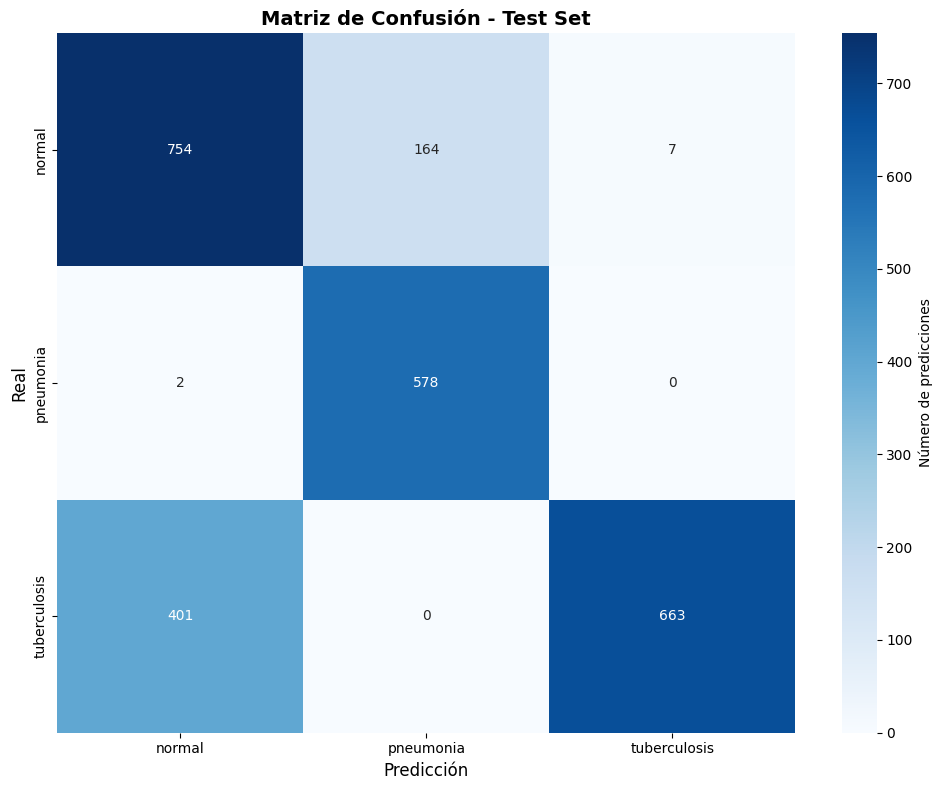


📋 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

      normal     0.6517    0.8151    0.7243       925
   pneumonia     0.7790    0.9966    0.8744       580
tuberculosis     0.9896    0.6231    0.7647      1064

    accuracy                         0.7766      2569
   macro avg     0.8067    0.8116    0.7878      2569
weighted avg     0.8204    0.7766    0.7749      2569


📊 MÉTRICAS POR CLASE:

NORMAL:
  Muestras: 925
  Accuracy: 0.8151
  Correctas: 754/925

PNEUMONIA:
  Muestras: 580
  Accuracy: 0.9966
  Correctas: 578/580

TUBERCULOSIS:
  Muestras: 1064
  Accuracy: 0.6231
  Correctas: 663/1064

✅ Análisis de métricas completado


In [ ]:
# Celda 10: Matriz de confusión y métricas por clase
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("📊 GENERANDO MÉTRICAS DETALLADAS")
print("=" * 60)

# Obtener predicciones en test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CONFIG['classes'],
            yticklabels=CONFIG['classes'],
            cbar_kws={'label': 'Número de predicciones'})
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusión - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN:")
print("=" * 60)
print(classification_report(all_labels, all_preds,
                          target_names=CONFIG['classes'],
                          digits=4))
print("=" * 60)

# Calcular métricas por clase manualmente para mejor visualización
print("\n📊 MÉTRICAS POR CLASE:")
print("=" * 60)
for i, class_name in enumerate(CONFIG['classes']):
    class_mask = (np.array(all_labels) == i)
    class_preds = np.array(all_preds)[class_mask]
    class_labels = np.array(all_labels)[class_mask]

    if len(class_labels) > 0:
        accuracy = (class_preds == class_labels).sum() / len(class_labels)
        print(f"\n{class_name.upper()}:")
        print(f"  Muestras: {len(class_labels)}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Correctas: {(class_preds == class_labels).sum()}/{len(class_labels)}")

print("\n✅ Análisis de métricas completado")

In [ ]:
# Celda 11: Guardar modelo entrenado
print("💾 GUARDANDO MODELO")
print("=" * 60)

# Crear directorio si no existe
import os
os.makedirs('/content/models', exist_ok=True)

# Información del modelo
model_info = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': CONFIG,
    'history': history,
    'best_val_loss': best_val_loss,
    'test_acc': test_acc,
    'class_to_idx': train_dataset.class_to_idx,
    'classes': CONFIG['classes']
}

# Guardar
model_path = '/content/models/chest_xray_efficientnet_b0.pt'
torch.save(model_info, model_path)

print(f"✅ Modelo guardado en: {model_path}")

# Verificar tamaño del archivo
file_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
print(f"📦 Tamaño del archivo: {file_size:.2f} MB")

# Crear archivo de texto con información
info_path = '/content/models/model_info.txt'
with open(info_path, 'w') as f:
    f.write("CHEST X-RAY CLASSIFIER - MODEL INFORMATION\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Architecture: EfficientNet-B0\n")
    f.write(f"Number of classes: {CONFIG['num_classes']}\n")
    f.write(f"Classes: {', '.join(CONFIG['classes'])}\n\n")
    f.write(f"Training:\n")
    f.write(f"  Epochs: {len(history['train_loss'])}\n")
    f.write(f"  Best Val Loss: {best_val_loss:.4f}\n")
    f.write(f"  Best Val Acc: {max(history['val_acc']):.4f}\n\n")
    f.write(f"Test Results:\n")
    f.write(f"  Test Loss: {test_loss:.4f}\n")
    f.write(f"  Test Acc: {test_acc:.4f}\n\n")
    f.write(f"Training Time: {total_time/60:.1f} minutes\n")

print(f"✅ Información guardada en: {info_path}")

print("\n" + "=" * 60)
print("🎉 TODO COMPLETADO")
print("=" * 60)

💾 GUARDANDO MODELO
✅ Modelo guardado en: /content/models/chest_xray_efficientnet_b0.pt
📦 Tamaño del archivo: 46.39 MB
✅ Información guardada en: /content/models/model_info.txt

🎉 TODO COMPLETADO


In [ ]:
# Celda 12: Descargar modelo a tu PC
from google.colab import files

print("📥 DESCARGANDO ARCHIVOS")
print("=" * 60)

# Descargar modelo (ADVERTENCIA: puede ser grande)
print("\n💾 Descargando modelo...")
print(f"   Tamaño: {file_size:.2f} MB")
print("   Esto puede tomar unos segundos...")

# Solo descargar si es menor a 100MB
if file_size < 100:
    files.download(model_path)
    print("✅ Modelo descargado")
else:
    print("⚠️  Modelo muy grande para descargar directamente")
    print("   Alternativas:")
    print("   1. Guardar en Google Drive")
    print("   2. Subir a HuggingFace Hub")
    print("   3. Usar modelo en Colab directamente")

# Descargar info (siempre pequeño)
print("\n📄 Descargando información del modelo...")
files.download(info_path)
print("✅ Información descargada")

print("\n" + "=" * 60)

📥 DESCARGANDO ARCHIVOS

💾 Descargando modelo...
   Tamaño: 46.39 MB
   Esto puede tomar unos segundos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Modelo descargado

📄 Descargando información del modelo...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Información descargada



In [ ]:
# Celda 12: Descargar modelo directamente
from google.colab import files

# Descargar el archivo .pt
files.download('/content/models/chest_xray_efficientnet_b0.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Crear y descargar script de carga
from google.colab import files

# Contenido del script
script_content = """# cargar_modelo.py
# Script para cargar el modelo entrenado de clasificación de rayos X

import torch
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms

def cargar_modelo(ruta_modelo='chest_xray_efficientnet_b0.pt'):
    '''
    Carga el modelo entrenado desde un archivo .pt

    Args:
        ruta_modelo: Ruta al archivo .pt del modelo

    Returns:
        model: Modelo cargado y listo para inferencia
        checkpoint: Información adicional (clases, métricas, etc.)
    '''
    # Cargar checkpoint
    checkpoint = torch.load(ruta_modelo, map_location='cpu')

    # Recrear arquitectura del modelo
    model = models.efficientnet_b0(pretrained=False)
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, 3)  # 3 clases

    # Cargar pesos entrenados
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Modo evaluación

    print("✅ Modelo cargado correctamente")
    print(f"📊 Clases: {checkpoint['classes']}")
    print(f"🎯 Test Accuracy: {checkpoint['test_acc']:.4f}")

    return model, checkpoint


def predecir_imagen(model, ruta_imagen, checkpoint):
    '''
    Hace predicción sobre una imagen de rayos X

    Args:
        model: Modelo cargado
        ruta_imagen: Ruta a la imagen de rayos X
        checkpoint: Información del modelo (incluye clases)

    Returns:
        clase_predicha: Nombre de la clase predicha
        probabilidades: Probabilidades para cada clase
    '''
    # Transformaciones (igual que en entrenamiento)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Cargar y preprocesar imagen
    imagen = Image.open(ruta_imagen).convert('RGB')
    imagen_tensor = transform(imagen).unsqueeze(0)  # Añadir dimensión batch

    # Predecir
    with torch.no_grad():
        output = model(imagen_tensor)
        probabilidades = torch.nn.functional.softmax(output[0], dim=0)
        pred_idx = output.argmax(1).item()

    clase_predicha = checkpoint['classes'][pred_idx]

    return clase_predicha, probabilidades.numpy()


# Ejemplo de uso
if __name__ == "__main__":
    print("=" * 60)
    print("CARGADOR DE MODELO - CLASIFICADOR DE RAYOS X")
    print("=" * 60)

    # Cargar modelo
    model, checkpoint = cargar_modelo('chest_xray_efficientnet_b0.pt')

    print("\\n📋 Información del modelo:")
    print(f"  • Arquitectura: EfficientNet-B0")
    print(f"  • Número de clases: {len(checkpoint['classes'])}")
    print(f"  • Clases: {', '.join(checkpoint['classes'])}")

    # Ejemplo de predicción (descomenta si tienes una imagen)
    # clase, probs = predecir_imagen(model, 'mi_rayo_x.jpg', checkpoint)
    # print(f"\\nPredicción: {clase}")
    # print("\\nProbabilidades:")
    # for i, clase_nombre in enumerate(checkpoint['classes']):
    #     print(f"  {clase_nombre}: {probs[i]:.4f}")

    print("\\n" + "=" * 60)
    print("✅ Modelo listo para usar")
    print("=" * 60)
"""

# Guardar archivo
with open('cargar_modelo.py', 'w') as f:
    f.write(script_content)

print("✅ Script creado: cargar_modelo.py")

# Descargar
print("📥 Descargando...")
files.download('cargar_modelo.py')

print("✅ cargar_modelo.py descargado")

✅ Script creado: cargar_modelo.py
📥 Descargando...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ cargar_modelo.py descargado
